<a href="https://colab.research.google.com/github/MorozovDesu/neural_network_technologies/blob/main/2_%D0%9B%D0%B0%D0%B1%D0%B0_%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B5%D0%B2%D1%8B%D0%B5_%D1%82%D0%B5%D1%85%D0%BD%D0%BE%D0%BB%D0%BE%D0%B3%D0%B8%D0%B8_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import sys
import seaborn as sns
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
import os
import h5py
import PIL
import cv2
import tensorflow as tf
import tensorflow.keras as keras

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams["figure.figsize"] = (14,8)

#Создание многослойной сети для работы с датасетом

In [68]:
class Network(object): # используется для описания нейронной сети
    def __init__(self, sizes): # конструктор класса
# self – указатель на объект класса
# sizes – список размеров слоев нейронной сети
        self.num_layers = len(sizes) # задаем количество слоев нейронной сети
        self.sizes = sizes # задаем список размеров слоев нейронной сети
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]] # задаем случайные начальные смещения
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])] # задаем случайные начальные веса связей

    def sigmoid(self,z): # определение сигмоидальной функции активации
        return 1.0/(1.0+np.exp(-z))

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = self.sigmoid(np.dot(w, a)+b)
        return a

    def SGD( # Стохастический градиентный спуск
        self # указатель на объект класса
        , training_data # обучающая выборка
        , epochs # количество эпох обучения
        , mini_batch_size # размер подвыборки
        , eta # скорость обучения
        , test_data # тестирующая выборка
        ):
        test_data = list(test_data) # создаем список объектов тестирующей выборки
        n_test = len(test_data) # вычисляем длину тестирующей выборки
        training_data = list(training_data) # создаем список объектов обучающей выборки
        n = len(training_data) # вычисляем размер обучающей выборки
        for j in range(epochs): # цикл по эпохам
            random.shuffle(training_data) # перемешиваем элементы обучающей выборки
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)] # создаем подвыборки
            for mini_batch in mini_batches: # цикл по подвыборкам
              #print(len(mini_batch[0][0]))
              self.update_mini_batch(mini_batch, eta) # один шаг градиентного спуска
            print ("Epoch {0}: {1} / {2}".format(j, self.evaluate(test_data), n_test)) # смотрим прогресс в обучении

    def update_mini_batch( # Шаг градиентного спуска
        self # указатель на объект класса
        , mini_batch # подвыборка
        , eta # скорость обучения
        ):
        nabla_b = [np.zeros(b.shape) for b in self.biases] # список градиентов dC/db для каждого слоя (первоначально заполняются нулями)
        nabla_w = [np.zeros(w.shape) for w in self.weights] # список градиентов dC/dw для каждого слоя (первоначально заполняются нулями)
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y) # послойно вычисляем градиенты dC/db и dC/dw для текущего прецедента (x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)] # суммируем градиенты dC/db для различных прецедентов текущей подвыборки
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)] # суммируем градиенты dC/dw для различных прецедентов текущей подвыборки
        self.weights = [w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)] # обновляем все веса w нейронной сети
        self.biases = [b-(eta/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)] # обновляем все смещения b нейронной сети

    def backprop( # Алгоритм обратного распространения
        self # указатель на объект класса
      ,x # вектор входных сигналов ,
      ,y # ожидаемый вектор выходных сигналов
      ):
        nabla_b = [np.zeros(b.shape) for b in self.biases] # список градиентов dC/db для каждого слоя (первоначально заполняются нулями)
        nabla_w = [np.zeros(w.shape) for w in self.weights] # список градиентов dC/dw для каждого слоя (первоначально заполняются нулями)
        # определение переменных
        activation = x # выходные сигналы слоя (первоначально соответствует выходным сигналам 1-го слоя или входным сигналам сети)
        activations = [x] # список выходных сигналов по всем слоям (первоначально содержит только выходные сигналы 1-го слоя)
        zs = [] # список активационных потенциалов по всем слоям (первоначально пуст)
        # прямое распространение
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b # считаем активационные потенциалы текущего слоя
            zs.append(z) # добавляем элемент (активационные потенциалы слоя) в конец списка
            activation = self.sigmoid(z) # считаем выходные сигналы текущего слоя, применяя сигмоидальную функцию активации к активационным потенциалам слоя
            activations.append(activation) # добавляем элемент (выходные сигналы слоя) в конец списка
  # обратное распространение
        delta = self.cost_derivative(activations[-1], y) * self.sigmoid_prime(zs[-1]) # считаем меру влияния нейронов выходного слоя L на величину ошибки (BP1)
        nabla_b[-1] = delta # градиент dC/db для слоя L (BP3)
        nabla_w[-1] = np.dot(delta, activations[-2].transpose()) # градиент dC/dw для слоя L (BP4)
        for l in range(2, self.num_layers):
          z = zs[-l] # активационные потенциалы l-го слоя (двигаемся по списку справа налево)
          sp = self.sigmoid_prime(z) # считаем сигмоидальную функцию от активационных потенциалов l-го слоя
          delta = np.dot(self.weights[-l+1].transpose(), delta) * sp # считаем меру влияния нейронов l-го слоя на величину ошибки (BP2)
          nabla_b[-l] = delta # градиент dC/db для l-го слоя (BP3)
          nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())# градиент dC/dw для l-го слоя (BP4)
        return (nabla_b, nabla_w)

    def evaluate(self, test_data): # Оценка прогресса в обучении
        test_results = [(np.argmax(self.feedforward(x)), y) for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y): # Вычисление частных производных стоимостной функции по выходным сигналам последнего слоя
      return (output_activations-y)

    def sigmoid_prime(self,z):# Производная сигмоидальной функции
      return self.sigmoid(z)*(1-self.sigmoid(z))


# Обучение нейросети с использованием keras
Желаемый результат

а=>1, б=>2, в=>3, г=>4, д=>5, е=>6, ё=>7, ж=>8, з=>9, и=>10, й=>11, к=>12, л=>13, м=>14, н=>15, о=>16, п=>17, р=>18, с=>19, т=>20, у=>21, ф=>22, х=>23, ц=>24, ч=>25, ш=>26, щ=>27, ъ=>28, ы=>29, ь=>30, э=>31, ю=>32, я=>33

In [69]:
input_folder = 'drive/MyDrive/archive/all_letters_image/all_letters_image/'
all_letters_filename = os.listdir(input_folder)
len(all_letters_filename)

14190

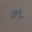

In [70]:
#Это одно из наших изображений. Размер каждого изображения составляет 32 на 32 пикселя.
#Затем мы преобразуем каждое изображение в 3d-массив numpy.
i = Image.open("drive/MyDrive/archive/all_letters_image/all_letters_image/20_102.png")
i

In [71]:
i_arr = np.array(i)
# i_arr
# Все 32 матрицы внутри этого массива представляют собой одно изображение.
# Каждая матрица представляет собой 1 строку этого изображения.
# Длина одной строки изображения составляет 32 пикселя, поэтому каждая матрица имеет 32 строки.
# Каждая строка матрицы имеет 4 столбца и представляет собой 1 пиксель. Для этого пикселя каждый столбец представляет собой значения цвета - насколько он красный, зеленый и синий - плюс непрозрачность цветов (последний столбец).
# Поэтому каждая матрица имеет размер 32 на 4. Общее количество пикселей в одном изображении составляет 32 * 32 = 1024.

# Каждое значение цвета находится в диапазоне [0:255].
# Это означает, что для каждого цвета существует 256 оттенков. В сумме все комбинации этих цветов дают нам 256ˆ3 = 16 777 216 возможных цветов.



In [72]:
from keras.preprocessing import image
import numpy as np

# Функция для преобразования изображения в тензор
# Параметры:
# - img_name: Имя файла изображения
# - input_folder: Путь к папке, где находится изображение
# Возвращает:
# - Тензорное представление изображения
def img_to_array(img_name, input_folder):
    # Загрузка изображения из указанной папки и изменение его размера до 32x32 пикселей
    img = image.load_img(input_folder + img_name, target_size=(32, 32))

    # Преобразование изображения в массив NumPy
    x = image.img_to_array(img)

    # Расширение размерности массива для подготовки его к обработке нейронной сетью
    return np.expand_dims(x, axis=0)

# Функция для преобразования списка имен изображений в тензор
# Параметры:
# - img_names: Список имен файлов изображений
# - input_folder: Путь к папке, где находятся изображения
# Возвращает:
# - Массив NumPy, содержащий тензоры всех изображений из списка
def data_to_tensor(img_names, input_folder):
    # Создание списка тензоров путем применения функции img_to_array к каждому имени изображения
    list_of_tensors = [img_to_array(img_name, input_folder) for img_name in img_names]

    # Стекирование отдельных тензоров вертикально для создания одного массива NumPy
    return np.vstack(list_of_tensors)


In [73]:
# Загрузка данных из CSV-файла в переменную "data"
data = pd.read_csv("drive/MyDrive/archive/all_letters_info.csv")
# Извлечение имен файлов изображений из столбца "file"
image_names = data['file']
letters = data[ 'letter']
backgrounds = data['background'].values
targets = data['label'].values
tensors = data_to_tensor(image_names, input_folder)
# tensors[0]


In [74]:
# Вывод размера (формы) массива тензоров
print('Форма тензоров:', tensors.shape)
# Вывод размера (формы) массива меток (целевых значений)
print('Форма меток (целевых значений):', targets.shape)

Форма тензоров: (14190, 32, 32, 3)
Форма меток (целевых значений): (14190,)


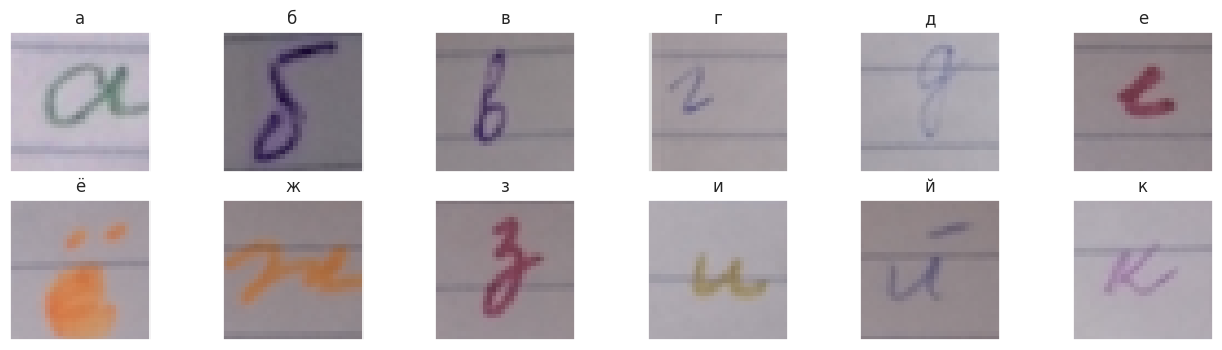

In [75]:
# Функция для отображения изображений из файлов с использованием OpenCV
# Параметры:
# - img_path: Путь к файлу изображения
# - ax: Объект для отображения изображения (область на графике)
def display_images(img_path, ax):
    # Загрузка изображения из указанного пути
    img = cv2.imread(input_folder + img_path)

    # Отображение изображения, преобразовав его из формата BGR в RGB
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Создание графического окна с определенными размерами
fig = plt.figure(figsize=(16, 4))

# Цикл для отображения 12 изображений
for i in range(12):
    # Создание области для каждого изображения внутри графического окна
    ax = fig.add_subplot(2, 6, i + 1, xticks=[], yticks=[], title=letters[i * 50])

    # Вызов функции для отображения изображения с указанным именем файла и заданной областью (ax)
    display_images(image_names[i * 50], ax)

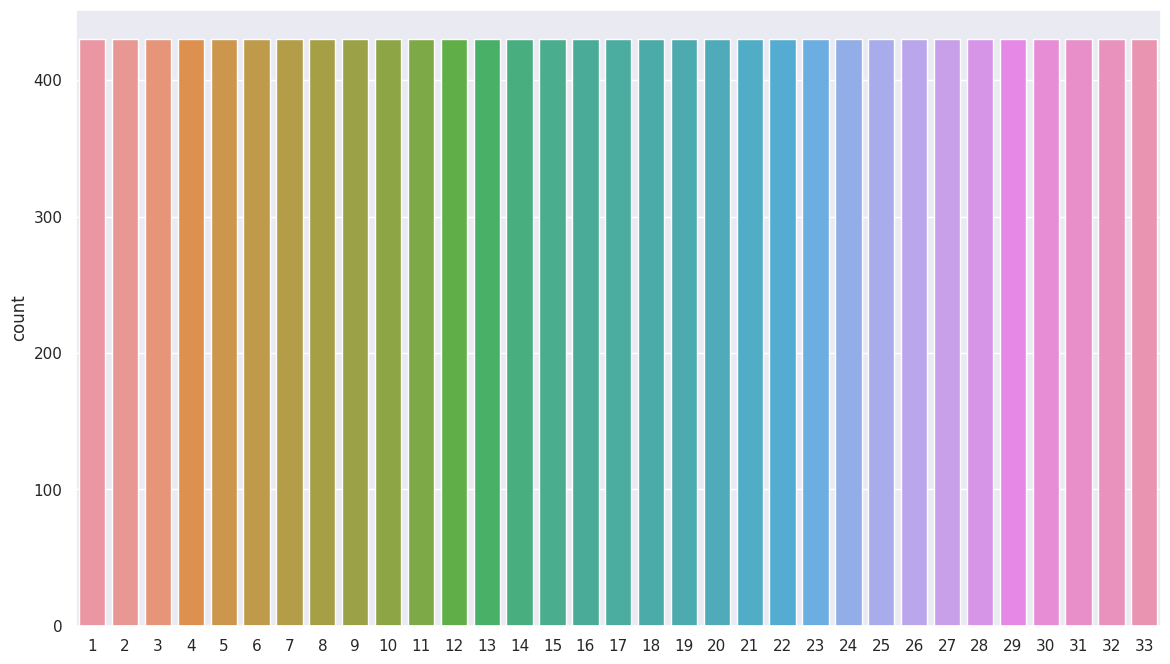

In [76]:
# Создание графика countplot
sns.set(style="darkgrid")
ax = sns.countplot(x=targets)

# Отображение графика
plt.show()

In [77]:
# Классы идеально сбалансированы, что очень важно для классификационной модели.
# Если классы несбалансированы, то модель будет пытаться максимизировать точность
# для большинства классов, оставляя без внимания другие классы, что приведет к менее точным прогнозам для меньшинств.

In [78]:
# Нормализация
# Для уменьшения влияния перепадов освещенности мы проводим нормализацию.
X = tensors.astype("float32")/255
# Кроме того, CNN быстрее сходится на данных [0...1], чем на [0...255]. Преобразуем входные данные к типу float, а затем разделим на 255 (максимальная яркость для каждого цвета).

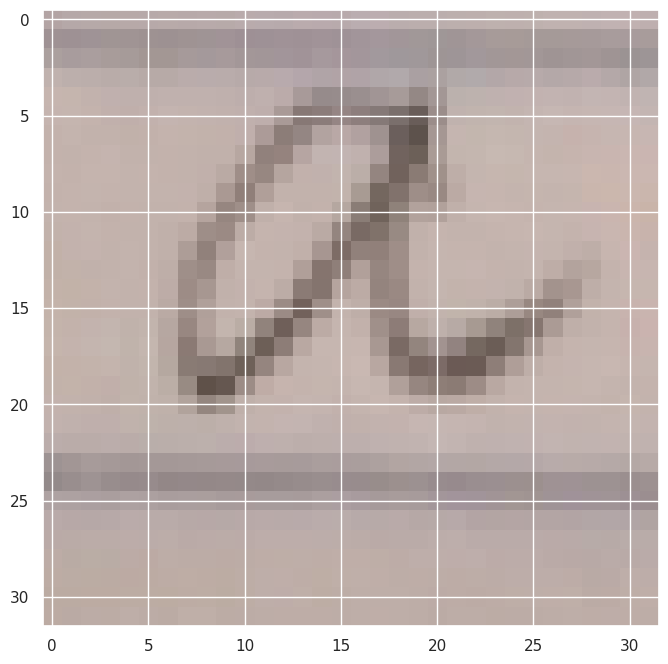

In [79]:
arr = X[2]
arr_ = np.squeeze(arr)
plt.imshow(arr_)
plt.show()

In [80]:
targets[0]

1

In [81]:
y = targets

img_rows, img_cols = 32, 32 # потому что наши картинки имеют размер 32 на 32 пикселя
num_classes = 33 # потому что в русинском алфавите 33 буквы

y = keras.utils.to_categorical(y-1, num_classes) # targets-1, потому что наш список начинается с 1, а не с 0, как ожидает keras

In [82]:
print(X.shape)
print(y.shape)

(14190, 32, 32, 3)
(14190, 33)


In [83]:
def captch_ex(file_name):
    img = cv2.imread(file_name)
    img_final = cv2.imread(file_name)
    img2gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, 180, 255, cv2.THRESH_BINARY)
    image_final = cv2.bitwise_and(img2gray, img2gray, mask=mask)
    ret, new_img = cv2.threshold(image_final, 180, 255, cv2.THRESH_BINARY)  # для черного текста использовать cv2.THRESH_BINARY_INV
    '''
            line  8 to 12  : Remove noisy portion
    '''
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,
                                                         3))  # для манипуляции ориентацией расширения, большое значение x означает большее горизонтальное расширение, большое значение y означает большее вертикальное расширение
    dilated = cv2.dilate(new_img, kernel, iterations=9)  # расширяем, чем больше итераций, тем больше расширение
    # for cv2.x.x

    contours, hierarchy = cv2.findContours(new_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)   # findContours возвращает 3 переменные для получения контуров
    for contour in contours:
        #  получаем ограничивающий прямоугольник контура
        [x, y, w, h] = cv2.boundingRect(contour)

        # Не рисуем маленькие контуры, которые не являются текстом
        if w < 35 and h < 35:
            continue

        # рисуем прямоугольник вокруг контура на исходном изображении
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 255), 2)

        '''
        #you can crop image and send to OCR  , false detected will return no text :)
        cropped = img_final[y :y +  h , x : x + w]

        s = file_name + '/crop_' + str(index) + '.png'
        cv2.imwrite(s , cropped)
        index = index + 1

        '''
    # записываем исходное изображение с добавленными контурами на диск
    cv2.imshow('captcha_result', img)
    cv2.waitKey()

In [84]:
file_name = 'drive/MyDrive/archive/all_letters_image/all_letters_image/04_100.png'
# captch_ex(file_name)

In [85]:
# Тензоры с градацией серого
X_grey = np.dot(X[...,:3], [0.299, 0.587, 0.114])
# X_grey = tf.expand_dims(X_grey, axis=3)
print ('Grayscaled Tensor shape:', X_grey.shape)

Grayscaled Tensor shape: (14190, 32, 32)


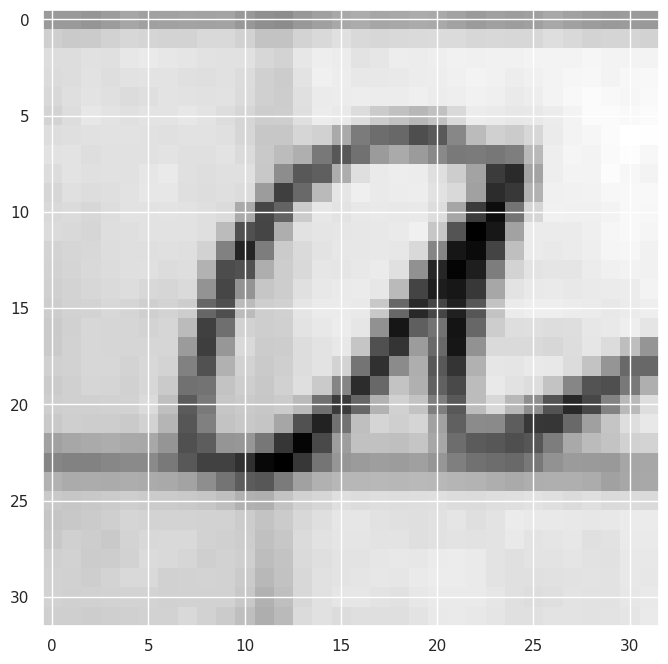

In [86]:
plt.imshow(X_grey[3], cmap=plt.get_cmap("gray"))

In [87]:
# Разделение набора данных на обучающую и тестовую выборки
# X: признаки/входные данные
# y: метки/целевые значения

# Разделение X и y на обучающую и тестовую выборки с размером тестовой выборки 10%
# random_state=1 гарантирует воспроизводимость результатов
X_train_whole, X_test, y_train_whole, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Дальнейшее разделение обучающей выборки на обучающую и проверочную выборки
# X_train_whole: полный набор признаков обучающей выборки
# y_train_whole: полный набор меток обучающей выборки

# Разделение X_train_whole и y_train_whole на обучающую и проверочную выборки с размером проверочной выборки 10%
# random_state=1 гарантирует воспроизводимость результатов
X_train, X_val, y_train, y_val = train_test_split(X_train_whole, y_train_whole, test_size=0.1, random_state=1)

In [88]:
# Создание генератора данных для аугментации изображений
datagen = ImageDataGenerator(
    featurewise_center=False,  # установить среднее значение входных данных равным 0 по всему набору данных
    samplewise_center=False,  # установить среднее значение каждого отдельного образца/изображения равным 0
    featurewise_std_normalization=False,  # нормализовать входные данные путем деления на стандартное отклонение набора данных
    samplewise_std_normalization=False,  # нормализовать каждый вход путем деления на его стандартное отклонение
    zca_whitening=False,  # применить ZCA-отбеливание
    rotation_range=10,  # случайное вращение изображений в заданном диапазоне (градусы, от 0 до 180)
    zoom_range=0.1,  # случайное изменение масштаба изображения
    width_shift_range=0.1,  # случайное смещение изображений по горизонтали (доля от общей ширины)
    height_shift_range=0.1,  # случайное смещение изображений по вертикали (доля от общей высоты)
    horizontal_flip=False,  # случайное отражение изображений по горизонтали
    vertical_flip=False)  # случайное отражение изображений по вертикали

# Подготовка генератора к обучающему набору данных
datagen.fit(X_train)

In [100]:
#Определение архитектуры модели

deep_RU_model = Sequential()
#Добавление первого слоя свертки
#filters: количество фильтров (ядер)
#kernel_size: размер ядра свертки
#padding: режим заполнения ('Same' - добавление нулевых значений по краям изображения)
#activation: функция активации ('relu' - выпрямительная функция)
#input_shape: размерность входных данных (img_rows, img_cols, 3) - 3 канала (RGB)
deep_RU_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (img_rows,img_cols,3)))
deep_RU_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
deep_RU_model.add(MaxPooling2D(pool_size=(2,2)))
deep_RU_model.add(Dropout(0.25))


deep_RU_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
deep_RU_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
deep_RU_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
deep_RU_model.add(Dropout(0.25))

#Выравнивание данных перед подачей на полносвязные слои
deep_RU_model.add(Flatten())
#Добавление первого полносвязного слоя
deep_RU_model.add(Dense(256, activation = "relu"))
#Добавление слоя Dropout
deep_RU_model.add(Dropout(0.5))
#Добавление последнего полносвязного слоя с функцией активации softmax для многоклассовой классификации
deep_RU_model.add(Dense(33, activation = "softmax"))

In [90]:
#Определение оптимизатора
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)

#Создание оптимизатора RMSprop с параметрами:
#learning_rate: скорость обучения (шаг градиентного спуска)
#rho: параметр альфа в формуле оптимизации
#epsilon: значение для стабильности численных вычислений

In [91]:
deep_RU_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Компиляция модели с параметрами:
# loss: функция потерь ("categorical_crossentropy" - категориальная перекрестная энтропия для многоклассовой классификации)
# optimizer: оптимизатор, ранее определенный (RMSprop)
# metrics: список метрик для оценки производительности модели (в данном случае указана только точность)

In [92]:
# Создание объекта learning_rate_reduction класса ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
# monitor: метрика для отслеживания (в данном случае 'val_acc' - точность на валидационных данных)
# patience: количество эпох без улучшений, после которого скорость обучения будет уменьшена
# verbose: уровень подробности вывода информации (1 для вывода сообщений)
# factor: коэффициент, на который будет уменьшаться скорость обучения
# min_lr: минимальное значение скорости обучения, после которого обучение прекращается

In [93]:
# Создание объекта es класса EarlyStopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=50)
# monitor: метрика для отслеживания (в данном случае 'val_accuracy' - точность на валидационных данных)
# mode: режим ('max' - максимизация метрики)
# verbose: уровень подробности вывода информации (1 для вывода сообщений)
# patience: количество эпох без улучшений, после которого обучение будет остановлено

# Создание объекта mc класса ModelCheckpoint
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# 'best_model.h5': имя файла, в котором будет сохранена модель с лучшей точностью на валидационных данных
# monitor: метрика для отслеживания (в данном случае 'val_accuracy' - точность на валидационных данных)
# mode: режим ('max' - максимизация метрики)
# verbose: уровень подробности вывода информации (1 для вывода сообщений)
# save_best_only: флаг, указывающий, сохранять только модель с лучшей точностью

In [102]:
history = deep_RU_model.fit(datagen.flow(X_train,y_train, batch_size=90), validation_data = (X_val, y_val),
                            epochs=139, callbacks=[learning_rate_reduction, es, mc])
# datagen.flow(X_train, y_train, batch_size=90): генератор данных для обучения модели, созданный с использованием данных X_train и y_train
# X_train: входные данные для обучения
# y_train: целевые данные для обучения
# batch_size: размер пакета данных, на котором будут обновляться веса модели
# validation_data=(X_val, y_val): данные для проверки производительности модели на каждой эпохе обучения
# X_val: входные данные для проверки
# y_val: целевые данные для проверки
# epochs: количество эпох обучения
# callbacks=[learning_rate_reduction, es, mc]: список колбэков, которые будут выполняться на различных этапах обучения
# learning_rate_reduction: уменьшение скорости обучения при отсутствии улучшений
# es: ранняя остановка обучения при отсутствии улучшений
# mc: сохранение модели с лучшей точностью на валидационных данных

RuntimeError: ignored

In [95]:
# saved_model = load_model('/kaggle/input/deep-ru-letters-cnn-tutorial/best_model.h5') удалить
saved_model = load_model('best_model.h5')

#Оценка производительности модели
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, valid_acc = saved_model.evaluate(X_val, y_val, verbose=0)

print('Train: %.3f, Valid: %.3f' % (train_acc, valid_acc))

Train: 0.978, Valid: 0.955


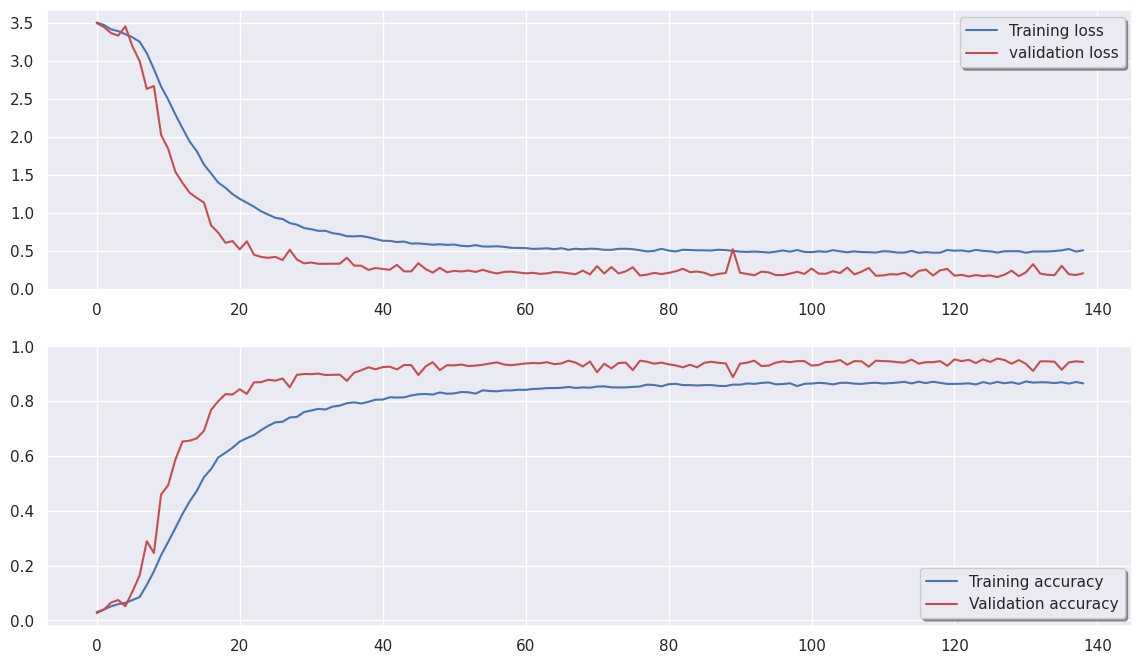

In [96]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(history.history['loss'], color='b', label="Training loss")  # График потерь на обучающем наборе данных
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss", axes=ax[0])  # График потерь на валидационном наборе данных
legend = ax[0].legend(loc='best', shadow=True)  # Легенда для графика потерь

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")  # График точности на обучающем наборе данных
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")  # График точности на валидационном наборе данных
legend = ax[1].legend(loc='best', shadow=True)  # Легенда для графика точности

# Создание графиков потерь и точности
# Параметры:
# history.history['loss']: значения функции потерь на обучающем наборе данных
# history.history['val_loss']: значения функции потерь на валидационном наборе данных
# history.history['accuracy']: значения точности на обучающем наборе данных
# history.history['val_accuracy']: значения точности на валидационном наборе данных

# Легенда и тени для каждого графика
# ax[0]: первый подграфик для графика потерь
# ax[1]: второй подграфик для графика точности

In [97]:
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('Test: %.3f' % (test_acc))

Test: 0.958


45/45 [==============================] - 3s 58ms/step


<Axes: >

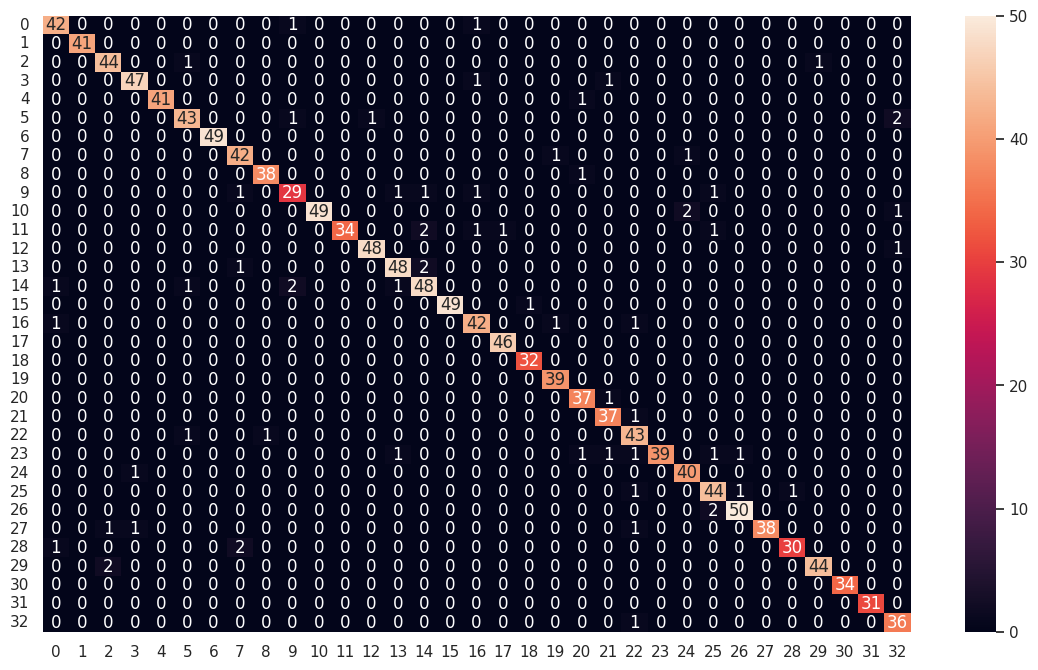

In [98]:
y_pred = deep_RU_model.predict(X_test)# Получение предсказаний модели для тестовых данных X_test
y_pred = np.argmax(y_pred, axis=1)# Преобразование предсказаний в индексы с наибольшим значением (классы)
y_test = np.argmax(y_test, axis=1)# Преобразование истинных меток y_test в индексы с наибольшим значением (классы)
confusion_mtx = confusion_matrix(y_test, y_pred)# Вычисление матрицы ошибок между истинными метками y_test и предсказанными метками y_pred
sns.heatmap(confusion_mtx, annot=True, fmt='d')
# Параметры:
# confusion_mtx: матрица ошибок
# annot=True: отображение значений в клетках тепловой карты
# fmt='d': формат чисел в клетках - десятичное целое число

45/45 [==============================] - 3s 59ms/step


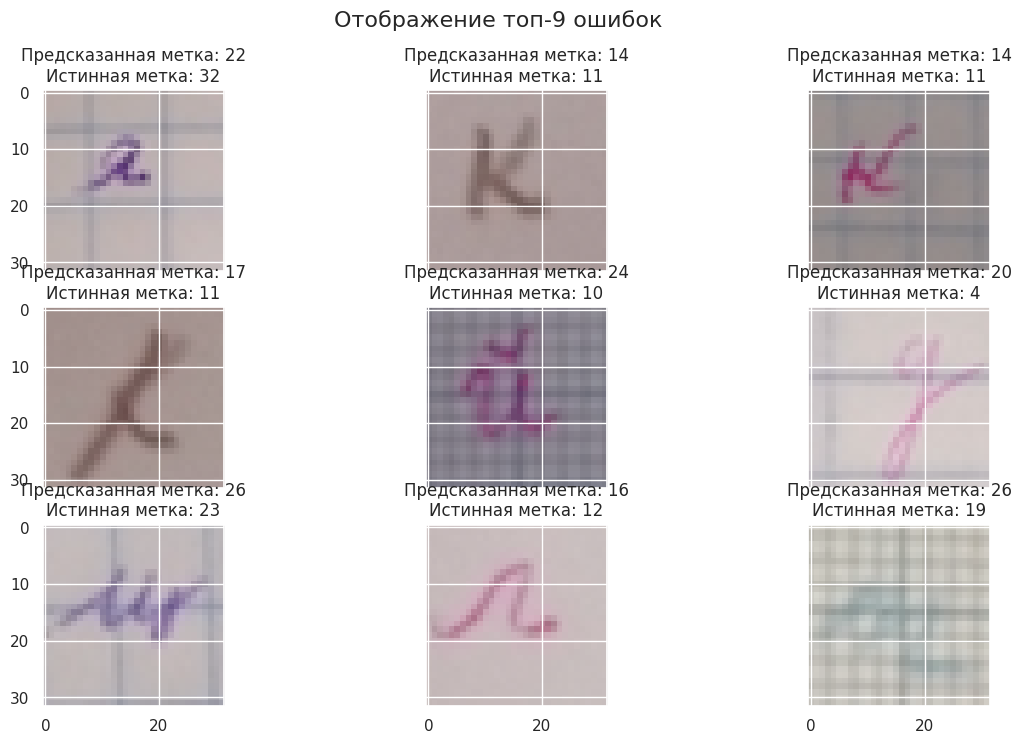

In [110]:
# Преобразование меток из формата one-hot в исходный формат меток
Y_true = y_test
# Предсказание значений на тестовом наборе данных с помощью сохраненной модели
Y_pred = saved_model.predict(X_test)
# Преобразование предсказанных значений из формата one-hot в исходный формат меток
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Вычисление ошибок путем сравнения предсказанных меток с истинными метками
errors = (Y_pred_classes - Y_true != 0)
# Получение предсказанных меток для ошибочных предсказаний
Y_pred_classes_errors = Y_pred_classes[errors]
# Получение предсказанных значений для ошибочных предсказаний
Y_pred_errors = Y_pred[errors]
# Получение истинных меток для ошибочных предсказаний
Y_true_errors = Y_true[errors]
# Получение изображений, соответствующих ошибочным предсказаниям
X_val_errors = X_test[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """Функция отображает 9 изображений с предсказанными и истинными метками"""
    n = 0
    nrows = 3
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    fig.suptitle("Отображение топ-9 ошибок", fontsize=16)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow((img_errors[error]))
            ax[row, col].set_title("Предсказанная метка: {}\nИстинная метка: {}".format(pred_errors[error], obs_errors[error]))
            n += 1

# Вероятности неправильно предсказанных символов
Y_pred_errors_prob = np.max(Y_pred_errors, axis=1)
# Предсказанные вероятности истинных значений в ошибочном наборе
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
# Разница между вероятностью предсказанной метки и истинной меткой
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
# Сортированный список ошибок по возрастанию разницы вероятностей
sorted_delta_errors = np.argsort(delta_pred_true_errors)
# Топ-9 ошибок
most_important_errors = sorted_delta_errors[-9:]
# Отображение топ-9 ошибок
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)


В процессе обработки данных мы сместили порядок букв на 1, чтобы он начинался с 0. Новый порядок выглядит следующим образом:

а=>0, б=>1, в=>2, г=>3, д=>4, е=>5, ё=>6, ж=>7

з=>8, и=>9, й=>10, к=>11, л=>12, м=>13, н=>14

о=>15, п=>16, р=>17, с=>18, т=>19, у=>20, ф=>21

х=>22, ц=>23, ч=>24, ш=>25, щ=>26, ъ=>27, ы=>28

ь=>29, э=>30, ю=>31, я=>32

Большинство ошибок, особенно во втором ряду, легко может быть сделано человеком таким же образом.